In [1]:
!nvidia-smi

Tue Dec 10 01:20:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="92jyh8UFL7X56QYAPtge")
project = rf.workspace("rf-projects").project("x-ray-id")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-y18irwyt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-y18irwyt
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done


In [4]:
!ls

output_mpox  sample_data  X-Ray-ID-1


In [5]:
import os
import json
import cv2
import random
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [6]:
data_dir = "./X-Ray-ID-1"
train_json = os.path.join(data_dir, "train", "_annotations.coco.json")
val_json = os.path.join(data_dir, "valid", "_annotations.coco.json")
train_img_dir = os.path.join(data_dir, "train")
val_img_dir = os.path.join(data_dir, "valid")

# Register the datasets
register_coco_instances("mpox_train", {}, train_json, train_img_dir)
register_coco_instances("mpox_val", {}, val_json, val_img_dir)

mri_metadata = MetadataCatalog.get("mpox_train")
dataset_dicts = DatasetCatalog.get("mpox_train")
print("Number of training images:", len(dataset_dicts))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Number of training images: 3064


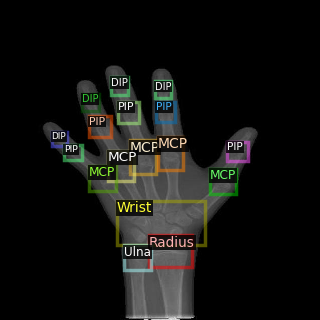

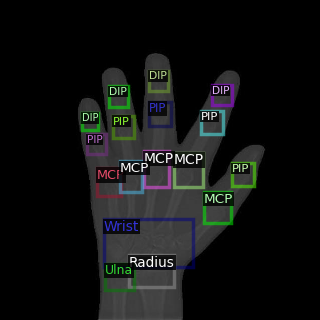

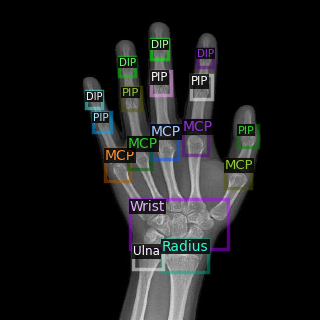

In [7]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mri_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mpox_train",)
cfg.DATASETS.TEST = ("mpox_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Pretrained weights from COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # may adjust
cfg.SOLVER.MAX_ITER = 8000    # may adjust depending on dataset size
cfg.SOLVER.STEPS = []         # no LR step downs by default

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # default 512, can adjust
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

cfg.OUTPUT_DIR = "./output_xray"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [9]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/10 01:20:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/10 01:20:21 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[12/10 01:20:25 d2.utils.events]:  eta: 0:10:13  iter: 19  total_loss: 5.818  loss_cls: 2.1  loss_box_reg: 0.3986  loss_rpn_cls: 3.159  loss_rpn_loc: 0.2297    time: 0.0884  last_time: 0.0771  data_time: 0.0099  last_data_time: 0.0041   lr: 4.9953e-06  max_mem: 1576M
[12/10 01:20:30 d2.utils.events]:  eta: 0:10:04  iter: 39  total_loss: 4.866  loss_cls: 1.975  loss_box_reg: 0.5935  loss_rpn_cls: 2.057  loss_rpn_loc: 0.2217    time: 0.0835  last_time: 0.0762  data_time: 0.0041  last_data_time: 0.0039   lr: 9.9902e-06  max_mem: 1576M
[12/10 01:20:32 d2.utils.events]:  eta: 0:10:04  iter: 59  total_loss: 3.2  loss_cls: 1.731  loss_box_reg: 0.6944  loss_rpn_cls: 0.5331  loss_rpn_loc: 0.2094    time: 0.0810  last_time: 0.0759  data_time: 0.0040  last_data_time: 0.0039   lr: 1.4985e-05  max_mem: 1576M
[12/10 01:20:33 d2.utils.events]:  eta: 0:09:56  iter: 79  total_loss: 2.518  loss_cls: 1.384  loss_box_reg: 0.7647  loss_rpn_cls: 0.1765  loss_rpn_loc: 0.1803    time: 0.0791  last_time: 0.075

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a threshold for inference
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("mpox_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "mpox_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[12/10 01:33:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_xray/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


WARNING [12/10 01:33:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/10 01:33:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/10 01:33:14 d2.data.datasets.coco]: Loaded 387 images in COCO format from ./X-Ray-ID-1/valid/_annotations.coco.json
[12/10 01:33:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/10 01:33:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/10 01:33:14 d2.data.common]: Serializing 387 elements to byte tensors and concatenating them all ...
[12/10 01:33:14 d2.data.common]: Serialized dataset takes 0.32 MiB
[12/10 01:33:14 d2.evaluation.evaluator]: Start inference on 387 batches
[12/10 01:33:14 d2.evaluation.

WARNING [12/10 01:33:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/10 01:33:36 d2.data.datasets.coco]: Loaded 387 images in COCO format from ./X-Ray-ID-1/valid/_annotations.coco.json


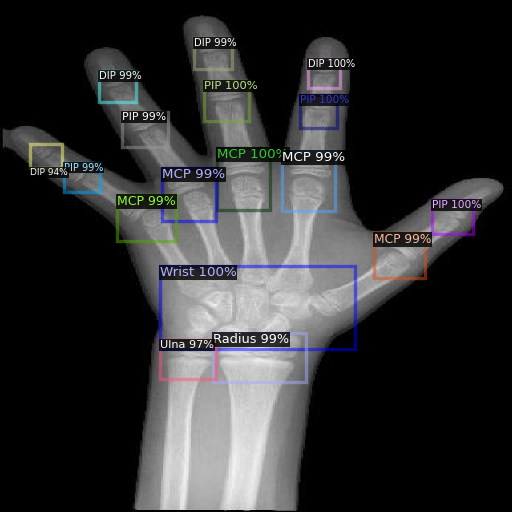

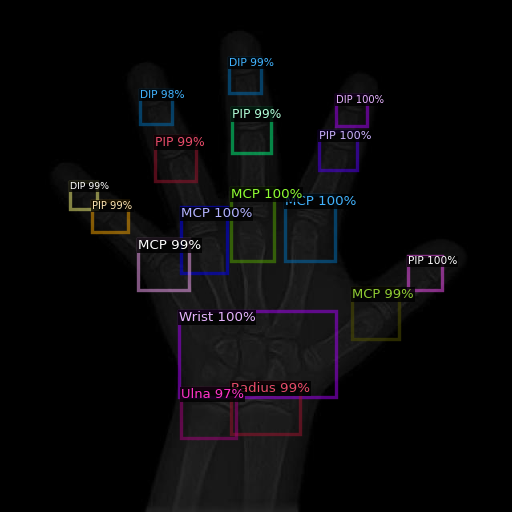

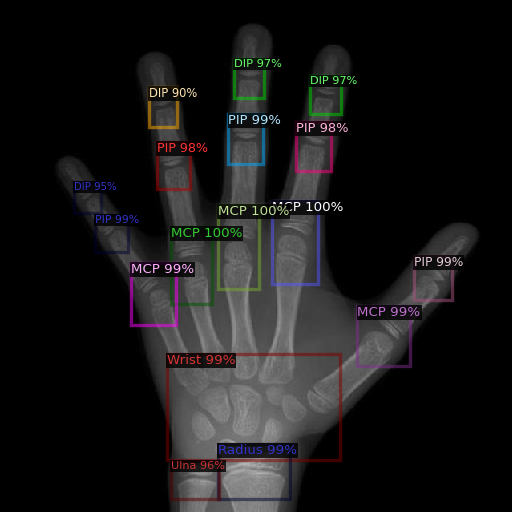

In [13]:
dataset_dicts_val = DatasetCatalog.get("mpox_val")

for d in random.sample(dataset_dicts_val, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=mri_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
